# A3TGCN

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric_temporal.nn.recurrent import A3TGCN2
from torch_geometric_temporal.signal import temporal_signal_split

In [3]:
shuffle=True
batch_size = 32

In [4]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ", len(list(dataset)))
print(next(iter(dataset)))

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x102f96d50>
Number of samples / sequences:  34249
Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])


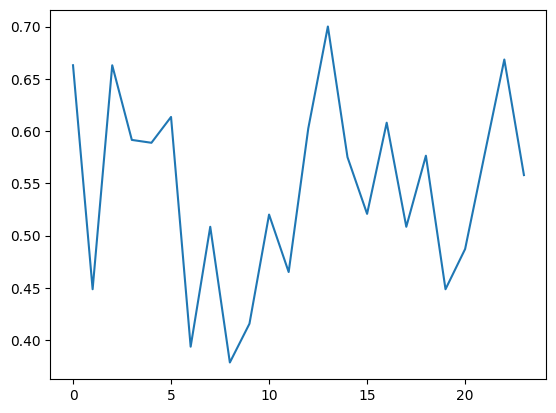

In [5]:
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
plt.plot(sensor_labels)

In [6]:
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(list(train_dataset)))
print("Number of test buckets: ", len(list(test_dataset)))

Number of train buckets:  27399
Number of test buckets:  6850


In [7]:
train_input = np.array(train_dataset.features) # (27399, 207, 2, 12)
train_target = np.array(train_dataset.targets) # (27399, 207, 12)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor)  # (B, N, F, T)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor)# (B, N, T)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [8]:
test_input = np.array(test_dataset.features)
test_target = np.array(test_dataset.targets)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor) # (B, N, F, T)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor)  # (B, N, T)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, shuffle=shuffle,drop_last=True)

In [18]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, batch_size):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN2(in_channels=node_features,  out_channels=32, periods=periods,batch_size=batch_size) # node_features=2, periods=12
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index) # x [b, 207, 2, 12]  returns h [b, 207, 12]
        h = F.relu(h) 
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12, batch_size=2)

TemporalGNN(
  (tgnn): A3TGCN2(
    (_base_tgcn): TGCN2(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [19]:
model = TemporalGNN(node_features=2, periods=12, batch_size=batch_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()


print('Net\'s state_dict:')
total_param = 0
for param_tensor in model.state_dict():
    print(param_tensor, '\t', model.state_dict()[param_tensor].size())
    total_param += np.prod(model.state_dict()[param_tensor].size())
print('Net\'s total params:', total_param)
#--------------------------------------------------
print('Optimizer\'s state_dict:')
for var_name in optimizer.state_dict():
    print(var_name, '\t', optimizer.state_dict()[var_name])

Net's state_dict:
tgnn._attention 	 torch.Size([12])
tgnn._base_tgcn.conv_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_z.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_z.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_z.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_r.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_r.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_r.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.bias 	 torch.Size([32])
tgnn._base_tgcn.conv_h.lin.weight 	 torch.Size([32, 2])
tgnn._base_tgcn.linear_h.weight 	 torch.Size([32, 64])
tgnn._base_tgcn.linear_h.bias 	 torch.Size([32])
linear.weight 	 torch.Size([12, 32])
linear.bias 	 torch.Size([12])
Net's total params: 6936
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'maximize': False, 'foreach': None, 'capturable': False, 'differentiable': False, 'fused': Non

In [20]:
for snapshot in train_dataset:
    static_edge_index = snapshot.edge_index
    break;

In [30]:
import torch

def calculate_mape(y_true, y_pred):
    """Calculate MAPE for PyTorch tensors"""
    return torch.mean(torch.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

# Set model to training mode
model.train()

for epoch in range(1):
    step = 0
    loss_list = []
    mape_list = []  # List to store MAPE values
    
    for encoder_inputs, labels in train_loader:
        # Forward pass
        y_hat = model(encoder_inputs, static_edge_index)
        
        # Compute the loss (RMSE or any other loss function you're using)
        loss = loss_fn(y_hat, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        # Track RMSE loss
        loss_list.append(loss.item())
        
        # Calculate MAPE and append to the mape_list
        mape = calculate_mape(labels, y_hat)
        mape_list.append(mape.item())
        
        # Step counter
        step += 1
        
        # Print RMSE every 100 steps
        if step % 100 == 0:
            avg_rmse = sum(loss_list) / len(loss_list)
            avg_mape = sum(mape_list) / len(mape_list)
            print(f"Step {step}, Avg Train RMSE: {avg_rmse:.4f}, Avg Train MAPE: {avg_mape:.4f}%")
    
    # Print epoch-level statistics for RMSE and MAPE
    avg_rmse = sum(loss_list) / len(loss_list)
    avg_mape = sum(mape_list) / len(mape_list)
    print(f"Epoch {epoch}, Avg Train RMSE: {avg_rmse:.4f}, Avg Train MAPE: {avg_mape:.4f}%")


Step 100, Avg Train RMSE: 0.4652, Avg Train MAPE: 164.6146%
Step 200, Avg Train RMSE: 0.4751, Avg Train MAPE: 166.3405%
Step 300, Avg Train RMSE: 0.4729, Avg Train MAPE: 166.4487%
Step 400, Avg Train RMSE: 0.4705, Avg Train MAPE: 167.4126%
Step 500, Avg Train RMSE: 0.4674, Avg Train MAPE: 167.7944%
Step 600, Avg Train RMSE: 0.4705, Avg Train MAPE: 168.1831%
Step 700, Avg Train RMSE: 0.4689, Avg Train MAPE: 168.0078%
Step 800, Avg Train RMSE: 0.4694, Avg Train MAPE: 168.1072%
Epoch 0, Avg Train RMSE: 0.4695, Avg Train MAPE: 168.3769%


In [22]:
model.eval()
step = 0
# Store for analysis
total_loss = []
for encoder_inputs, labels in test_loader:
    # Get model predictions
    y_hat = model(encoder_inputs, static_edge_index)
    # Mean squared error
    loss = loss_fn(y_hat, labels)
    total_loss.append(loss.item())
    # Store for analysis below
    #test_labels.append(labels)
    #predictions.append(y_hat)
    

print("Test MSE: {:.4f}".format(sum(total_loss)/len(total_loss)))

Test MSE: 0.6027


In [23]:
sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in y_hat])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (32,)


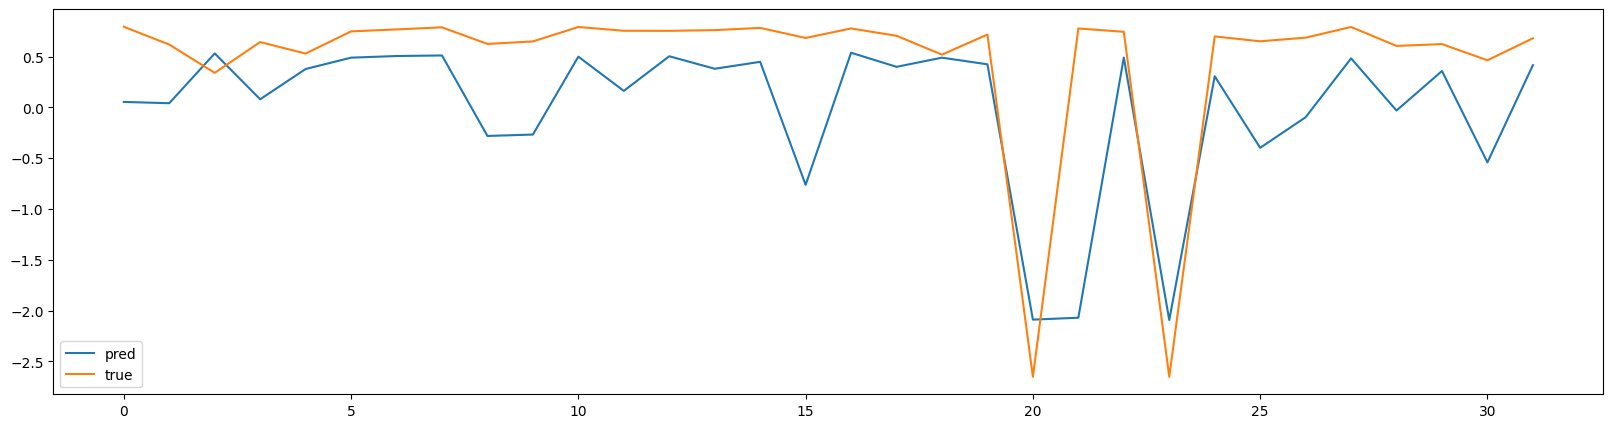

In [24]:
plt.figure(figsize=(20, 5))
plt.plot(preds, label="pred", linestyle='-', marker=None)
plt.plot(labs, label="true", linestyle='-', marker=None)


plt.legend()
plt.show()